# Fold a histogram spectra through the MagEIS isotropic response functions

In [4]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

Create a true exponential spectra with E0t and J0t parameters. Then use that spectra and fold it through the MagEIS response functions to get the true counts.

In [5]:
# Spectra parameters
E0t = 100 # keV
J0t = 1E4 # 1/(cm^2 sr s keV)

# Initialize the response function
R = mageis_response.R_iso(101) # RBSP MagEIS LOW.
E = R.E*1000 # Energy channel array in keV.
n_ch = 15

# Define an exponential spectra.
def spectra(Earr, J0, E0):
    return(J0*np.exp(-Earr/E0))

# Now create the "true" counts drawn from the parent distribution. This assumes there
# is no uncertanity.
true_lambda = np.nan*np.zeros(n_ch)
for i in range(n_ch):
    true_lambda[i] = scipy.integrate.trapz(spectra(E, J0t, E0t)*R.response(i), x=E)

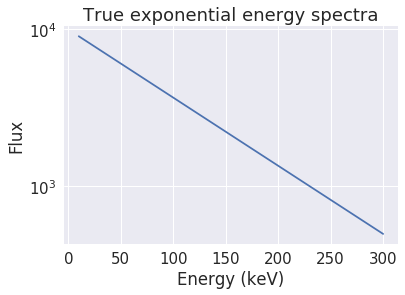

In [6]:
plt.plot(E, spectra(E, J0t, E0t)); plt.title('True exponential energy spectra')
plt.yscale('log'); plt.xlabel('Energy (keV)'); plt.ylabel('Flux');

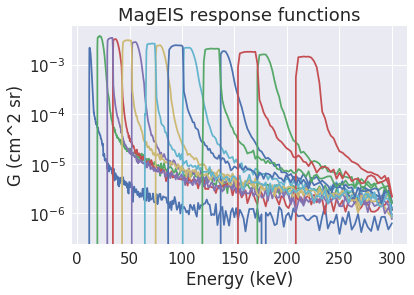

In [7]:
for i in range(n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS response functions'); plt.yscale('log');

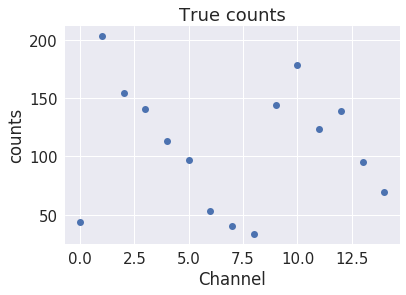

In [8]:
plt.plot(range(n_ch), true_lambda, 'o'); 
plt.ylabel('counts'); plt.xlabel('Channel'); plt.title('True counts');

Now draw observed counts from true_lambda assuming a Poisson process

In [9]:
np.random.seed(123)
c_obs = np.random.poisson(true_lambda)

### Model the spectra 

Here we are going to model the exponential spectra

In [10]:
# Make a 2-D array of reponses (nE x Nch)
response = np.ones((len(E), n_ch), dtype=object)
for i in range(response.shape[1]):
    response[:, i] = R.response(i)

Define the histogram spectra bins, and find indicies of E array that correpond to those bin edges.

In [11]:
# Define the energy channel boundaries for the spectra
nE = 10
E_bins = np.linspace(E[0], E[-1], num=nE+1)
istart = [np.where(E >= i)[0][0] for i in E_bins][:-1]
iend = [np.where(E <= i)[0][-1] for i in E_bins][1:]

#for (est, een, ist, ien) in zip(E_bins[:-1], E_bins[1:], istart, iend):
#    print(est, een, E[ist], E[ien])

In [45]:
m = pm.Model()

def lam(JJ):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    My implementation of trapezium is not the fastest, but it will do.
    """
    lams = n_ch*[0]
    
    for ch in range(n_ch):
        f = pm.math.dot(JJ[ch], R.response(ch)) #response[:, ch]
        lams[ch] = pm.Deterministic('lam{}'.format(ch), 
                                    0.5*pm.math.dot((f[1:] + f[:-1]), (E[1:] - E[:-1])))
    return lams

with m:
    # Prior stocastic variables
    J = pm.Uniform('J', lower=1, upper=1E6, shape=n_ch)
    
    lams = lam(J)
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs)#, shape=len(c_obs))
    trace = pm.sample(1E4, tuning=1000, cores=3)#, step=pm.Metropolis)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 3 jobs)
NUTS: [J_interval__]
INFO:pymc3:NUTS: [J_interval__]
100%|██████████| 10500/10500.0 [01:41<00:00, 103.23it/s]


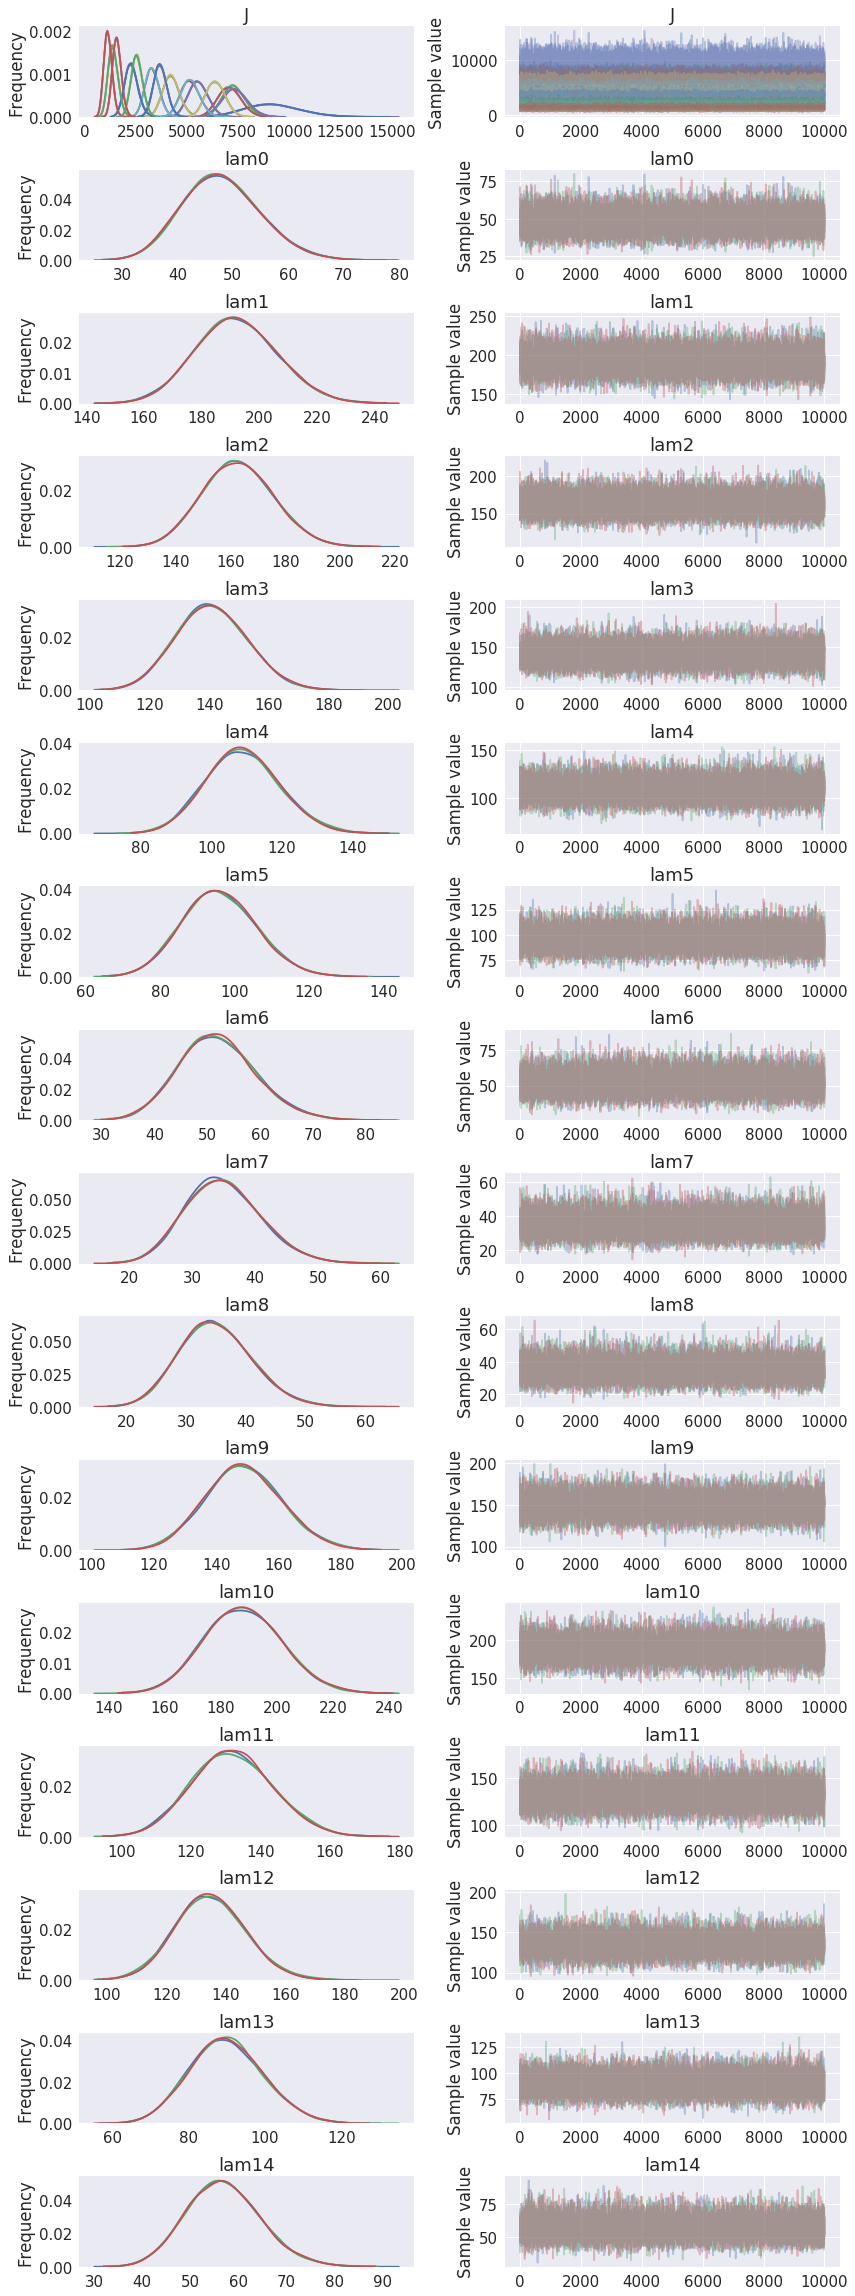

In [47]:
pm.traceplot(trace);

In [52]:
pm.summary(trace)

mean           sd  mc_error      hpd_2.5      hpd_97.5  \
J__0   9212.112394  1326.347726  4.805049  6773.469050  11936.019810   
J__1   7281.767525   530.518907  2.250297  6246.766168   8325.793030   
J__2   7087.134374   554.144794  2.197175  6029.886844   8176.900801   
J__3   5555.019487   465.823351  1.797018  4675.092476   6486.416755   
J__4   4240.139527   403.540455  1.448320  3485.143116   5063.643197   
J__5   3310.861314   340.348385  1.479810  2655.846699   3983.563293   
J__6   2295.393603   316.943058  1.284177  1678.234589   2919.898337   
J__7   1405.849496   239.878850  0.965223   956.733081   1888.475253   
J__8   1155.476573   196.581945  0.756177   781.708304   1542.804021   
J__9   7344.052839   598.954355  2.205375  6187.133131   8539.603646   
J__10  6398.388023   466.477800  2.019225  5485.583314   7307.783594   
J__11  5161.841110   453.771237  1.817911  4288.301328   6052.229727   
J__12  3699.009886   320.039339  1.245041  3077.353438   4337.411190   
J__13  2563.270233   269.223337  1.128821  2045.786369   3095.328156   
J__14  1586.669963   211.663054  0.872032  1172.362194   2000.919185   
lam0     47.977727     6.907770  0.025025    35.276996     62.164147   
lam1    192.027324    13.990302  0.059343   164.733327    219.559297   
lam2    162.997788    12.744837  0.050533   138.682035    188.061447   
lam3    140.948938    11.819456  0.045596   118.622324    164.581520   
lam4    109.003556    10.374032  0.037233    89.594456    130.173810   
lam5     95.978845     9.866389  0.042898    76.990570    115.479861   
lam6     51.959361     7.174438  0.029069    37.989126     66.095876   
lam7     34.962731     5.965660  0.024005    23.793444     46.965378   
lam8     35.009445     5.956179  0.022911    23.684750     46.744966   
lam9    148.973974    12.149778  0.044736   125.505880    173.225700   
lam10   188.045558    13.709559  0.059344   161.218665    214.772258   
lam11   132.024959    11.606155  0.046497   109.682339    154.798523   
lam12   134.955220    11.676362  0.045424   112.274614    158.246746   
lam13    89.979447     9.450649  0.039625    71.814015    108.656478   
lam14    57.001338     7.604024  0.031328    42.117274     71.883298   

              n_eff      Rhat  
J__0   61801.946612  0.999988  
J__1   61367.266133  0.999983  
J__2   66092.113927  0.999956  
J__3   64855.109611  1.000018  
J__4   63967.024772  0.999954  
J__5   56901.256127  0.999957  
J__6   60201.381939  0.999953  
J__7   62332.509725  1.000004  
J__8   63844.449453  1.000028  
J__9   65644.267741  1.000019  
J__10  59531.138333  0.999982  
J__11  59710.203207  0.999965  
J__12  60938.722874  0.999953  
J__13  61773.380278  0.999980  
J__14  57450.419244  0.999952  
lam0   61801.946612  0.999988  
lam1   61367.266133  0.999983  
lam2   66092.113927  0.999956  
lam3   64855.109611  1.000018  
lam4   63967.024772  0.999954  
lam5   56901.256127  0.999957  
lam6   60201.381939  0.999953  
lam7   62332.509725  1.000004  
lam8   63844.449453  1.000028  
lam9   65644.267741  1.000019  
lam10  59531.138333  0.999982  
lam11  59710.203207  0.999965  
lam12  60938.722874  0.999953  
lam13  61773.380278  0.999980  
lam14  57450.419244  0.999952

In [53]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(len(c_obs))]

j_mean = np.mean(trace['J'], axis=0)
j_std = np.std(trace['J'], axis=0)

c_Err = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) for i in range(len(c_obs))])
c_Err

array([[  35.49698157,   62.47400369],
       [ 165.51541937,  220.44308998],
       [ 139.23021846,  188.76844492],
       [ 118.81723063,  164.86467212],
       [  89.68738907,  130.36043294],
       [  77.56547827,  116.12311129],
       [  38.86805581,   67.10823382],
       [  24.24807192,   47.59505782],
       [  24.26435608,   47.5633276 ],
       [ 126.03526759,  173.93686637],
       [ 162.20292429,  215.90040707],
       [ 110.38199697,  155.5913789 ],
       [ 112.80180477,  158.88742682],
       [  72.32914015,  109.28969916],
       [  43.0295497 ,   73.01562852]])

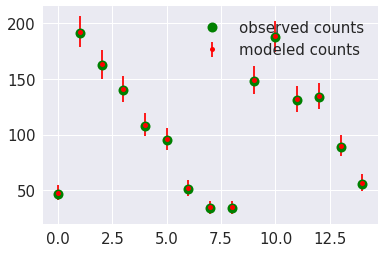

In [77]:
plt.plot(np.arange(n_ch), c_obs, 'go', label='observed counts', ms=10);
plt.errorbar(np.arange(n_ch), c_mean, fmt='ro', yerr=c_std, label='modeled counts', ms=5);
plt.legend();

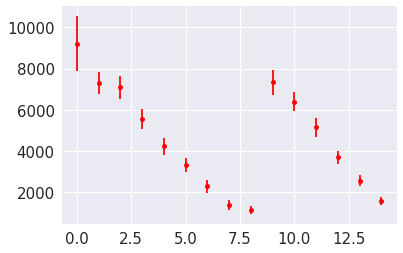

In [78]:
plt.errorbar(np.arange(n_ch), j_mean, fmt='ro', yerr=j_std, label='modeled flux', ms=5);